In [5]:
# dowload executable file from server
!wget ftp://68.183.140.238/download_google_drive_files.sh

# execute file to download required data (will take approximately 15 minutes)
# the executable automatically unzips the files
!bash download_google_drive_files.sh

--2018-11-19 22:24:38--  ftp://68.183.140.238/download_google_drive_files.sh
           => ‘download_google_drive_files.sh’
Connecting to 68.183.140.238:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD not needed.
==> SIZE download_google_drive_files.sh ... 1401
==> PASV ... done.    ==> RETR download_google_drive_files.sh ... done.
Length: 1401 (1.4K) (unauthoritative)

download_google_dri 100%[===================>]   1.37K  --.-KB/s    in 0s      

2018-11-19 22:24:39 (151 MB/s) - ‘download_google_drive_files.sh’ saved [1401]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1930      0 --:--:-- --:--:-- --:--:--  1930
100 2080k    0 2080k    0     0  5013k      0 --:--:-- --:--:-- --:--:--  145M
Download of \'https://drive.google.com/open?id=16reUvzJ0eYpNsht_6PyUJG0h

# Keras tutorial using TensorFlow backend
The majority of the notebook was created by Kevin Mader for the "Quick, Draw! Doodle Recognition Challenge" on Kaggle 

https://www.kaggle.com/c/quickdraw-doodle-recognition

https://www.kaggle.com/kmader/quickdraw-baseline-lstm-reading-and-submission/notebook

Kaggle description of the challenge:

"Quick, Draw!" was released as an experimental game to educate the public in a playful way about how AI works. The game prompts users to draw an image depicting a certain category, such as ”banana,” “table,” etc. The game generated more than 1B drawings, of which a subset was publicly released as the basis for this competition’s training set. That subset contains 50M drawings encompassing 340 label categories.

Sounds fun, right? Here's the challenge: since the training data comes from the game itself, drawings can be incomplete or may not match the label. You’ll need to build a recognizer that can effectively learn from this noisy data and perform well on a manually-labeled test set from a different distribution.

Your task is to build a better classifier for the existing Quick, Draw! dataset. By advancing models on this dataset, Kagglers can improve pattern recognition solutions more broadly. This will have an immediate impact on handwriting recognition and its robust applications in areas including OCR (Optical Character Recognition), ASR (Automatic Speech Recognition) & NLP (Natural Language Processing).

![alt text](https://hexacoto.files.wordpress.com/2016/11/screen-shot-2016-11-17-at-5-22-04-pm.png)

# Kaggle description of the dataset
The Quick Draw Dataset is a collection of millions of drawings across 300+ categories, contributed by players of Quick, Draw! The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located.

Two versions of the data are given. The raw data is the exact input recorded from the user drawing, while the simplified version removes unnecessary points from the vector information. (For example, a straight line may have been recorded with 8 points, but since you only need 2 points to uniquely identify a line, 6 points can be dropped.) The simplified files are much smaller and provide effectively the same information.

For this competition, you may use the raw files, the simplified files, or both. You can find out more details about the drawing format on the quickdraw-dataset github page.

Your models should predict the correct "word" of the drawing. IMPORTANT: Some "words" are actually more than one word! The training data aligns to the Quick Draw dataset that that was previously released, and uses spaces to delimit multi-word labels. The Kaggle metric for this competition requires labels with no spaces, so you will need to adjust your label predictions to replace spaces with underscores. For example, "roller coaster" should be predicted as "roller_coaster". You may predict up to 3 guesses per drawing. See the Evaluation page for the correct format.

Here we will use the simplified dataset!

# Outline of the project
1. preprocess data using 1D convolutions
2. stack two LSTM (Long Short-Term Memory) neural networks
3. apply two dense neural network layers
4. classify shape
5. create submittable file for Kaggle competition

# CNN - Convolutional Neural Network
Images are represented as matrices of numbers. For greyscale images these numbers range from 0 to 255. Matrices are convolved to created a feature map. For example a 7x7 matrix convolved with a 3x3 matrix may look like

![alt text](https://anhvnn.files.wordpress.com/2018/02/convolve.png?w=1000)

The type of convolution applied depends on the desired outcome.

![alt text](http://i1.wp.com/ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-05-at-11-03-00-pm.png?resize=342%2C562&ssl=1)

1D convolutions are sometimes used before Recurrent Neural Networks (RNNs) because they decrease the amount of data seen by the RNN. This is a preprocessing technique that makes sequences smaller by downsampling. After the 1D convolution, only higher level features are seen by the RNN.

# LSTM - Long Short-Term Memory
LSTM networks are units of a Recurrent Neural Network (RNN) commonly composed of four parts. 1) cell - remembers values over a certain time 2) input gate - controls the extent to which a new value flows into the cell 3) output gate -  controls the extent to which the cell value controls the output activation 4) forget gate - controlling the extent to which the value remains in the cell

# Model Parameters
Here we keep track of the relevant parameters for the data preprocessing, model construction and training

In [13]:
#batch_size = 32 # local machine will likely require a batch size much smaller than 2048
batch_size = 2048
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 50

# check data storage on colab
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   39G  302G  12% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G  8.0K  6.4G   1% /var/colab
/dev/sda1       365G   40G  326G  11% /opt/bin
shm             6.0G     0  6.0G   0% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [0]:
# Imports
%matplotlib inline

# if connecting to a Google Drive account is necessary
"""
# connecting to your google drive account where the training and testing data is stored
# give permission to colab to connect to google drive
# go to link at output of this cell blowck, allow permission, and paste in authorization code 
from google.colab import drive
drive.mount('/content/gdrive')
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob

# garbage collection (automated memory management)
import gc
gc.enable()

# function for calculating the mean accuracy across k number of predictions for multiclass classification problems
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)

# function for checking the number of available GPUs
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [8]:
# add the location of the data to the path
working_dir = os.getcwd()

# location of test data file
test_path = os.path.join(working_dir, 'test_simplified.csv')

# location of pre-trained weights or location of place to save weights
weight_path = os.path.join(working_dir, "{}_weights.best.hdf5").format('stroke_lstm_model')

print(working_dir)
print(test_path)
print(weight_path)

/content
/content/test_simplified.csv
/content/stroke_lstm_model_weights.best.hdf5


In [11]:
from ast import literal_eval

# glob here finds all the csv files containing the data to train on
ALL_TRAIN_PATHS = glob(os.path.join(working_dir, '*.csv'))

test_raw_file = os.path.join(working_dir, 'test_raw.csv')
test_simplified_file = os.path.join(working_dir, 'test_simplified.csv')

if test_raw_file in ALL_TRAIN_PATHS: ALL_TRAIN_PATHS.remove(test_raw_file)
if test_simplified_file in ALL_TRAIN_PATHS: ALL_TRAIN_PATHS.remove(test_simplified_file)

print("number of csv files containing data: ", len(ALL_TRAIN_PATHS))

# column names of the csv files
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=STROKE_COUNT, 
                         padding='post').swapaxes(0, 1)
def read_batch(samples=5, 
               start_row=0,
               max_rows = 1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in ALL_TRAIN_PATHS:
        c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
        c_df.columns=COL_NAMES
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it)
    
    return full_df

['/content/necklace.csv', '/content/anvil.csv', '/content/binoculars.csv', '/content/cake.csv', '/content/frog.csv', '/content/tooth.csv', '/content/bucket.csv', '/content/ant.csv', '/content/angel.csv', '/content/toaster.csv', '/content/van.csv', '/content/piano.csv', '/content/bush.csv', '/content/sweater.csv', '/content/blueberry.csv', '/content/fence.csv', '/content/matches.csv', '/content/postcard.csv', '/content/zigzag.csv', '/content/ice cream.csv', '/content/camel.csv', '/content/eye.csv', '/content/headphones.csv', '/content/bench.csv', '/content/spider.csv', '/content/mailbox.csv', '/content/suitcase.csv', '/content/campfire.csv', '/content/toothpaste.csv', '/content/clarinet.csv', '/content/beach.csv', '/content/hourglass.csv', '/content/trumpet.csv', '/content/banana.csv', '/content/pig.csv', '/content/horse.csv', '/content/hot air balloon.csv', '/content/spoon.csv', '/content/tent.csv', '/content/couch.csv', '/content/The Mona Lisa.csv', '/content/donut.csv', '/content/tre

# Reading and Parsing
Since it is too much data (23GB) to read in at once, we just take a portion of it for training, validation and hold-out testing. This should give us an idea about how well the model works, but leaves lots of room for improvement later

In [0]:
# take a portion of the data from the unzipped csv files to be training data, validation data, and testing data
train_args = dict(samples=TRAIN_SAMPLES, 
                  start_row=0, 
                  max_rows=int(TRAIN_SAMPLES*1.5))
valid_args = dict(samples=VALID_SAMPLES, 
                  start_row=train_args['max_rows']+1, 
                  max_rows=VALID_SAMPLES+25)
test_args = dict(samples=TEST_SAMPLES, 
                 start_row=valid_args['max_rows']+train_args['max_rows']+1, 
                 max_rows=TEST_SAMPLES+25)

# read in the data using the definitions in previous cell
train_df = read_batch(**train_args)
valid_df = read_batch(**valid_args)
test_df = read_batch(**test_args)

# encode labels between 0 and num_classes-1
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])
print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))

words 340 => The Eiffel Tower, The Great Wall of China, The Mona Lisa, airplane, alarm clock, ambulance, angel, animal migration, ant, anvil, apple, arm, asparagus, axe, backpack, banana, bandage, barn, baseball, baseball bat, basket, basketball, bat, bathtub, beach, bear, beard, bed, bee, belt, bench, bicycle, binoculars, bird, birthday cake, blackberry, blueberry, book, boomerang, bottlecap, bowtie, bracelet, brain, bread, bridge, broccoli, broom, bucket, bulldozer, bus, bush, butterfly, cactus, cake, calculator, calendar, camel, camera, camouflage, campfire, candle, cannon, canoe, car, carrot, castle, cat, ceiling fan, cell phone, cello, chair, chandelier, church, circle, clarinet, clock, cloud, coffee cup, compass, computer, cookie, cooler, couch, cow, crab, crayon, crocodile, crown, cruise ship, cup, diamond, dishwasher, diving board, dog, dolphin, donut, door, dragon, dresser, drill, drums, duck, dumbbell, ear, elbow, elephant, envelope, eraser, eye, eyeglasses, face, fan, feathe

# Stroke-based Classification
Here we use the stroke information to train a model and see if the strokes give us a better idea of what the shape could be.
A stroke is a line made with the drawing utencil. The stacking function above builds the object by creating a list of strokes made (lines) used to build up the drawing.

In [0]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

(255000, 196, 3)


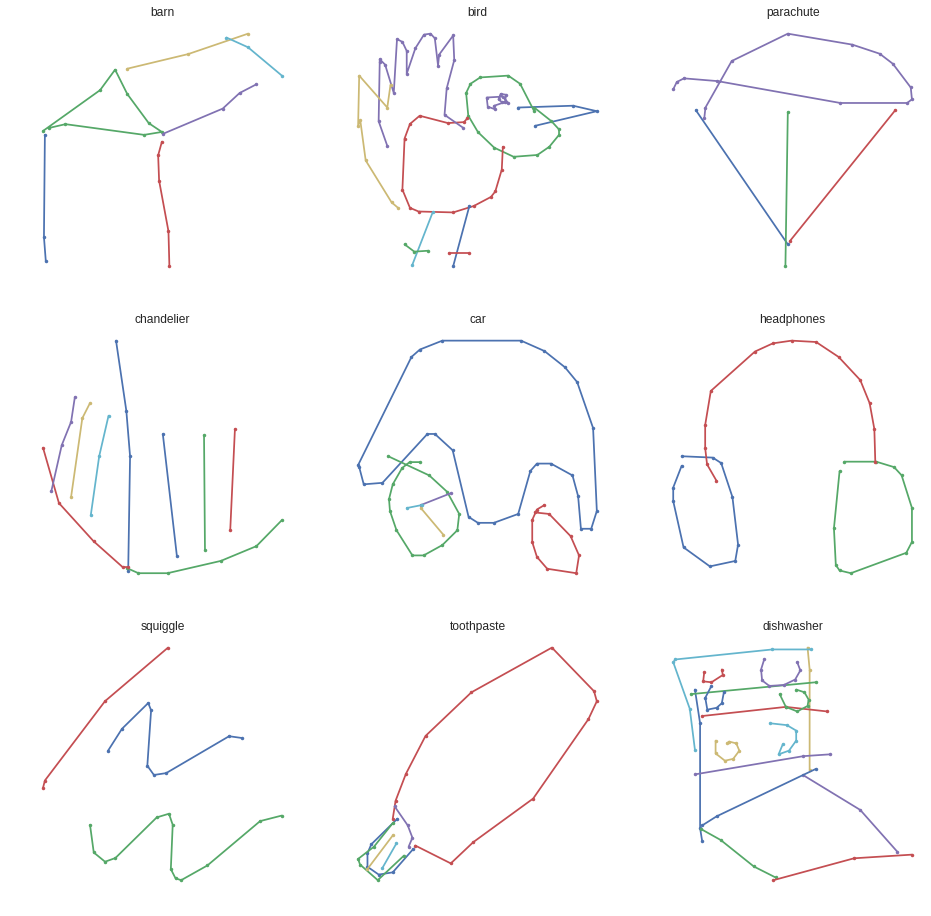

In [0]:
# plot some of the drawings from the training set along with their labels
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(train_X.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = train_X[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(word_encoder.classes_[np.argmax(train_y[c_id])])

# LSTM to Parse Strokes
The model suggested from the tutorial is

![alt text](https://www.tensorflow.org/versions/master/images/quickdraw_model.png)

In [0]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout

if len(get_available_gpus())>0:
    print(len(get_available_gpus()), "GPUs are available")
    from keras.layers import CuDNNLSTM as LSTM # this one is about 3x faster on GPU instances
stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (None,)+train_X.shape[2:]))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
stroke_read_model.add(Conv1D(48, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(64, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(96, (3,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = True))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = False))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(512))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'softmax'))

# load partially pre-trained weights if desired
stroke_read_model.load_weights(weight_path)

stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model.summary()

/content/gdrive/My Drive/Colab Notebooks/stroke_lstm_model_weights.best.hdf5
1 GPUs are available
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, None, 3)           12        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 48)          768       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 48)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          15424     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 96)          18528     
____________________________________________

In [0]:
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, 
                                   verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [0]:
# Train the data for n epochs
from IPython.display import clear_output
stroke_read_model.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 10,
                      callbacks = callbacks_list)
#clear_output()

Train on 255000 samples, validate on 25500 samples
Epoch 1/2
255000/255000 [==============================] - 103s 405us/step - loss: 2.1946 - categorical_accuracy: 0.4708 - top_3_accuracy: 0.6853 - val_loss: 1.8812 - val_categorical_accuracy: 0.5400 - val_top_3_accuracy: 0.7462

Epoch 00001: val_loss improved from inf to 1.88116, saving model to /content/gdrive/My Drive/Colab Notebooks/stroke_lstm_model_weights.best.hdf5
Epoch 2/2
255000/255000 [==============================] - 98s 386us/step - loss: 2.1596 - categorical_accuracy: 0.4771 - top_3_accuracy: 0.6911 - val_loss: 1.8579 - val_categorical_accuracy: 0.5444 - val_top_3_accuracy: 0.7474

Epoch 00002: val_loss improved from 1.88116 to 1.85790, saving model to /content/gdrive/My Drive/Colab Notebooks/stroke_lstm_model_weights.best.hdf5


In [0]:
stroke_read_model.load_weights(weight_path)
lstm_results = stroke_read_model.evaluate(test_X, test_y, batch_size = batch_size)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[1], 100*lstm_results[2]))

17000/17000 [==============================] - 2s 121us/step
Accuracy: 54.5%, Top 3 Accuracy 74.8%


                         precision    recall  f1-score   support

       The Eiffel Tower       0.62      0.78      0.69        50
The Great Wall of China       0.38      0.12      0.18        50
          The Mona Lisa       0.61      0.82      0.70        50
               airplane       0.65      0.74      0.69        50
            alarm clock       0.54      0.54      0.54        50
              ambulance       0.55      0.36      0.43        50
                  angel       0.65      0.64      0.65        50
       animal migration       0.40      0.46      0.43        50
                    ant       0.59      0.66      0.62        50
                  anvil       0.58      0.58      0.58        50
                  apple       0.70      0.78      0.74        50
                    arm       0.68      0.50      0.57        50
              asparagus       0.48      0.48      0.48        50
                    axe       0.68      0.42      0.52        50
               backpack 

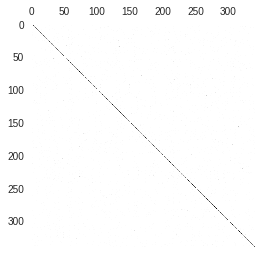

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
test_cat = np.argmax(test_y, 1)
pred_y = stroke_read_model.predict(test_X, batch_size = batch_size)
pred_cat = np.argmax(pred_y, 1)
plt.matshow(confusion_matrix(test_cat, pred_cat))
print(classification_report(test_cat, pred_cat, 
                            target_names = [x for x in word_encoder.classes_]))

# Reading Point by Point

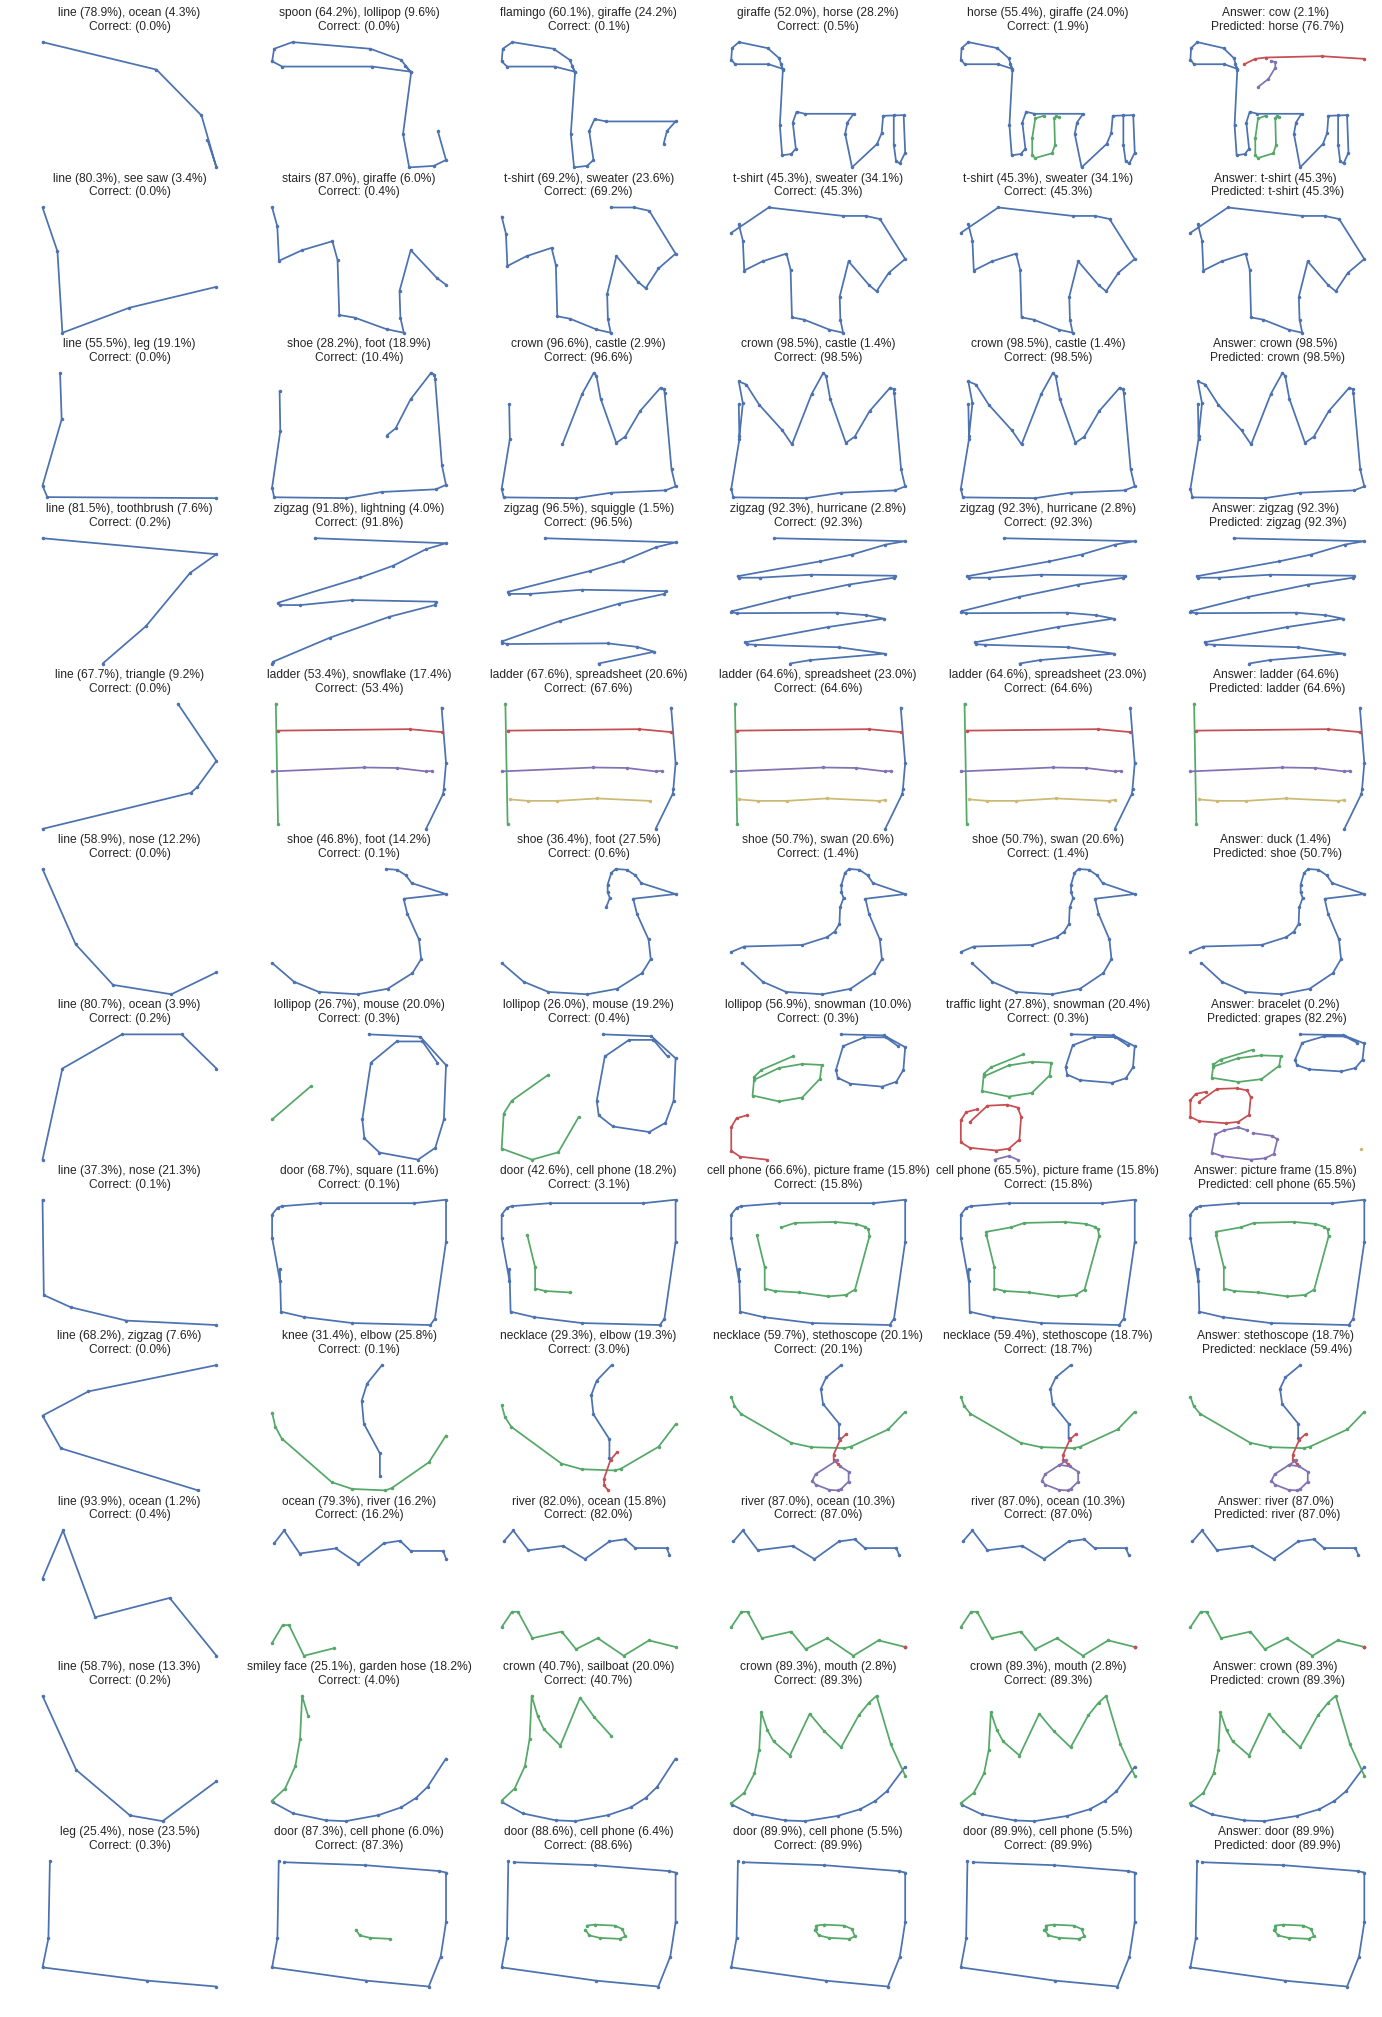

In [0]:
points_to_use = [5, 15, 20, 30, 40, 50]
points_to_user = [108]
samples = 12
word_dex = lambda x: word_encoder.classes_[x]
rand_idxs = np.random.choice(range(test_X.shape[0]), size = samples)
fig, m_axs = plt.subplots(len(rand_idxs), len(points_to_use), figsize = (24, samples/8*24))
for c_id, c_axs in zip(rand_idxs, m_axs):
    res_idx = np.argmax(test_y[c_id])
    goal_cat = word_encoder.classes_[res_idx]
    
    for pt_idx, (pts, c_ax) in enumerate(zip(points_to_use, c_axs)):
        test_arr = test_X[c_id, :].copy()
        test_arr[pts:] = 0 # short sequences make CudnnLSTM crash, ugh 
        stroke_pred = stroke_read_model.predict(np.expand_dims(test_arr,0))[0]
        top_10_idx = np.argsort(-1*stroke_pred)[:10]
        top_10_sum = np.sum(stroke_pred[top_10_idx])
        
        test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
        lab_idx = np.cumsum(test_arr[:,2]-1)
        for i in np.unique(lab_idx):
            c_ax.plot(test_arr[lab_idx==i,0], 
                    np.max(test_arr[:,1])-test_arr[lab_idx==i,1], # flip y
                      '.-')
        c_ax.axis('off')
        if pt_idx == (len(points_to_use)-1):
            c_ax.set_title('Answer: %s (%2.1f%%) \nPredicted: %s (%2.1f%%)' % (goal_cat, 100*stroke_pred[res_idx]/top_10_sum, word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum))
        else:
            c_ax.set_title('%s (%2.1f%%), %s (%2.1f%%)\nCorrect: (%2.1f%%)' % (word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum, 
                                                                 word_dex(top_10_idx[1]), 100*stroke_pred[top_10_idx[1]]/top_10_sum, 
                                                                 100*stroke_pred[res_idx]/top_10_sum))

# Submission
We can create a submission to Kaggle using the following model

In [0]:
print(test_path)
sub_df = pd.read_csv(test_path)
sub_df['drawing'] = sub_df['drawing'].map(_stack_it)

/content/gdrive/My Drive/Colab Notebooks/input/test_simplified.csv


In [0]:
sub_vec = np.stack(sub_df['drawing'].values, 0)
sub_pred = stroke_read_model.predict(sub_vec, verbose=True, batch_size=batch_size)

112199/112199 [==============================] - 13s 114us/step


In [0]:
top_3_pred = [word_encoder.classes_[np.argsort(-1*c_pred)[:3]] for c_pred in sub_pred]

In [0]:
top_3_pred = [' '.join([col.replace(' ', '_') for col in row]) for row in top_3_pred]
top_3_pred[:3]

['radio stereo submarine',
 'hockey_puck hamburger bathtub',
 'camel castle squiggle']

# Show some predictions

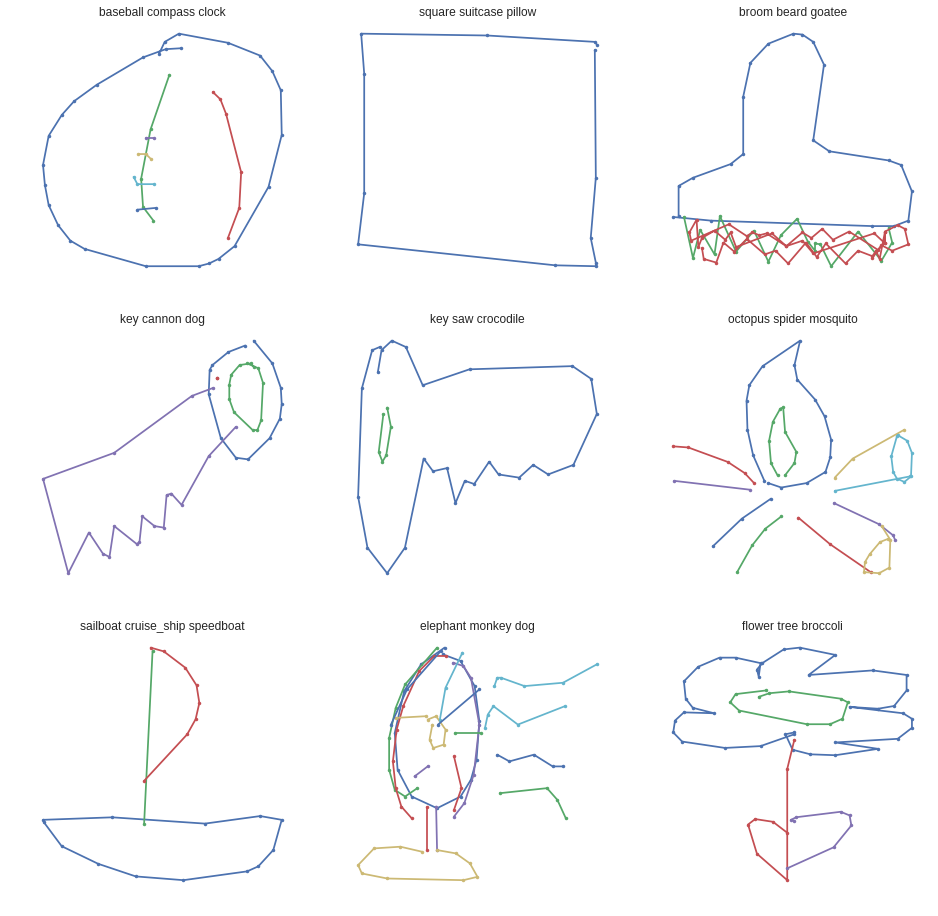

In [0]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(sub_vec.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = sub_vec[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(top_3_pred[c_id])

In [0]:
inc = 1 # save file increment number
submission_file_path = working_dir+"/submission_"+str(inc)+".csv"

while os.path.isfile(submission_file_path):
  inc = inc + 1
  submission_file_path = working_dir+"/submission_"+str(inc)+".csv"

with open (submission_file_path,'a') as submission_file:
  sub_df['word'] = top_3_pred
  sub_df[['key_id', 'word']].to_csv(submission_file, index=False)

print("Saving as next increment: %d" %inc)
print("Saved file: %s" %"submission_"+str(inc)+".csv")

Saving as next increment: 4
Saved file: submission_4.csv


Things to try:
1. different optimizers
2. increasing the amount of data used 
3. different NN architecture
4. run for more epochs with patience increased